# Clustering of Breast Cancer Data

This project explores the measurements that are associated with the diagnosis of benign and malign breast tumors.
1. The dataset is cleaned: NaN are removed and correct datatypes are enforced
2. The data s standardized using the Z-Score
3. An EDA is performed to show the distribution of the scaled feature values for both groups
4. Two feature sets are selected using two different methods:
   - Hypothesis testing (MAnn Whitney-U and Kruskall Wallis test) applied to test for difference between malign and benign groups
   - PCA (select the features capturing most fo the data's variance)
5. The data is clustered using K-Means and the features selected using both Hypothesis Testing and PCA. The number optimal number of K-clusters is determined by the maximum Silhouette Score. The elbow plot is generated for both the Silhouette and the Inertia Scores.
6. The data is clustered using Mean shift clustering
7. The data is clustered using DBSCAN

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline

# 1. Data import and cleaning

In [2]:
df = pd.read_csv('breast_cancer_data.csv')
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
# Drop the last column because it only has missing values and the id column because it does not provided valuable information for this project
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)

# Convert diagnosis column to int
#df['diagnosis'] = np.round(df['diagnosis']=='M')

# Show clean version of data
display(df.info())
display(df.isna().sum())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

None

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


# 2. Data Standardization

In [5]:
# Get column names from features
feature_names = df.columns.to_list()
feature_names.remove('diagnosis')
feature_names

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [6]:
df_scaled = df.copy()
display(df_scaled.head(10))
df_scaled[feature_names] = StandardScaler().fit_transform(df_scaled[feature_names].to_numpy())
display(df_scaled.head(10))

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,M,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,M,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,M,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,M,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100
5,M,-0.476375,-0.835335,-0.387148,-0.505650,2.237421,1.244335,0.866302,0.824656,1.005402,...,-0.165498,-0.313836,-0.115009,-0.244320,2.048513,1.721616,1.263243,0.905888,1.754069,2.241802
6,M,1.170908,0.160649,1.138125,1.095295,-0.123136,0.088295,0.300072,0.646935,-0.064325,...,1.368983,0.322883,1.368325,1.275220,0.518640,0.021215,0.509552,1.196716,0.262476,-0.014730
7,M,-0.118517,0.358450,-0.072867,-0.218965,1.604049,1.140102,0.061026,0.281950,1.403355,...,0.163763,0.401048,0.099449,0.028859,1.447961,0.724786,-0.021054,0.624196,0.477640,1.726435
8,M,-0.320167,0.588830,-0.184080,-0.384207,2.201839,1.684010,1.219096,1.150692,1.965600,...,-0.161357,0.822813,-0.031609,-0.248363,1.662757,1.818310,1.280035,1.391616,2.389857,1.288650
9,M,-0.473535,1.105439,-0.329482,-0.509063,1.582699,2.563358,1.738872,0.941760,0.797298,...,-0.244190,2.443109,-0.286278,-0.297409,2.320295,5.112877,3.995433,1.620015,2.370444,6.846856


# 3. EDA, plot the distribution from each feature and for each diagnosis group (malign and benign)

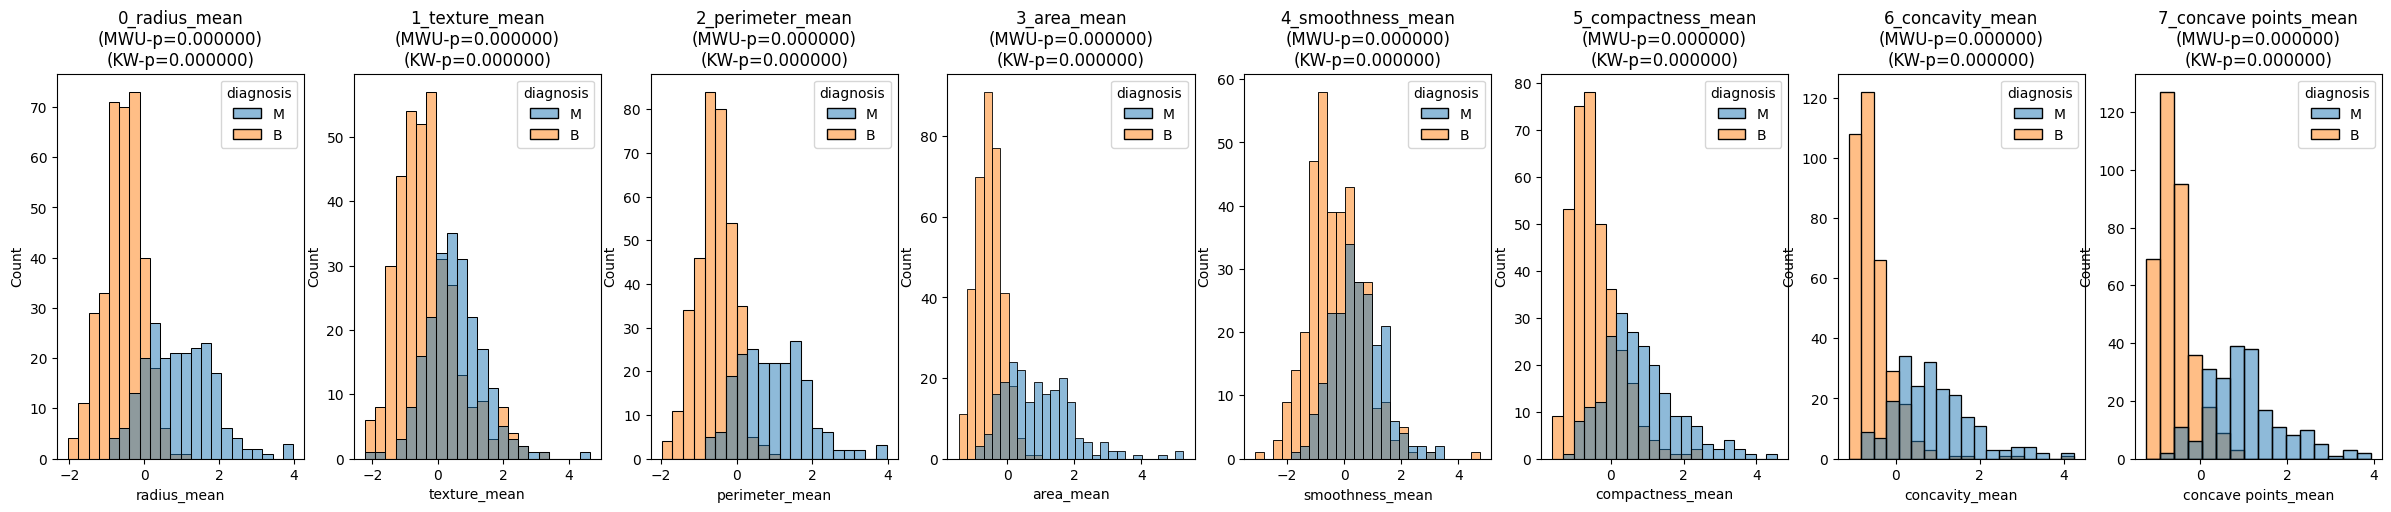

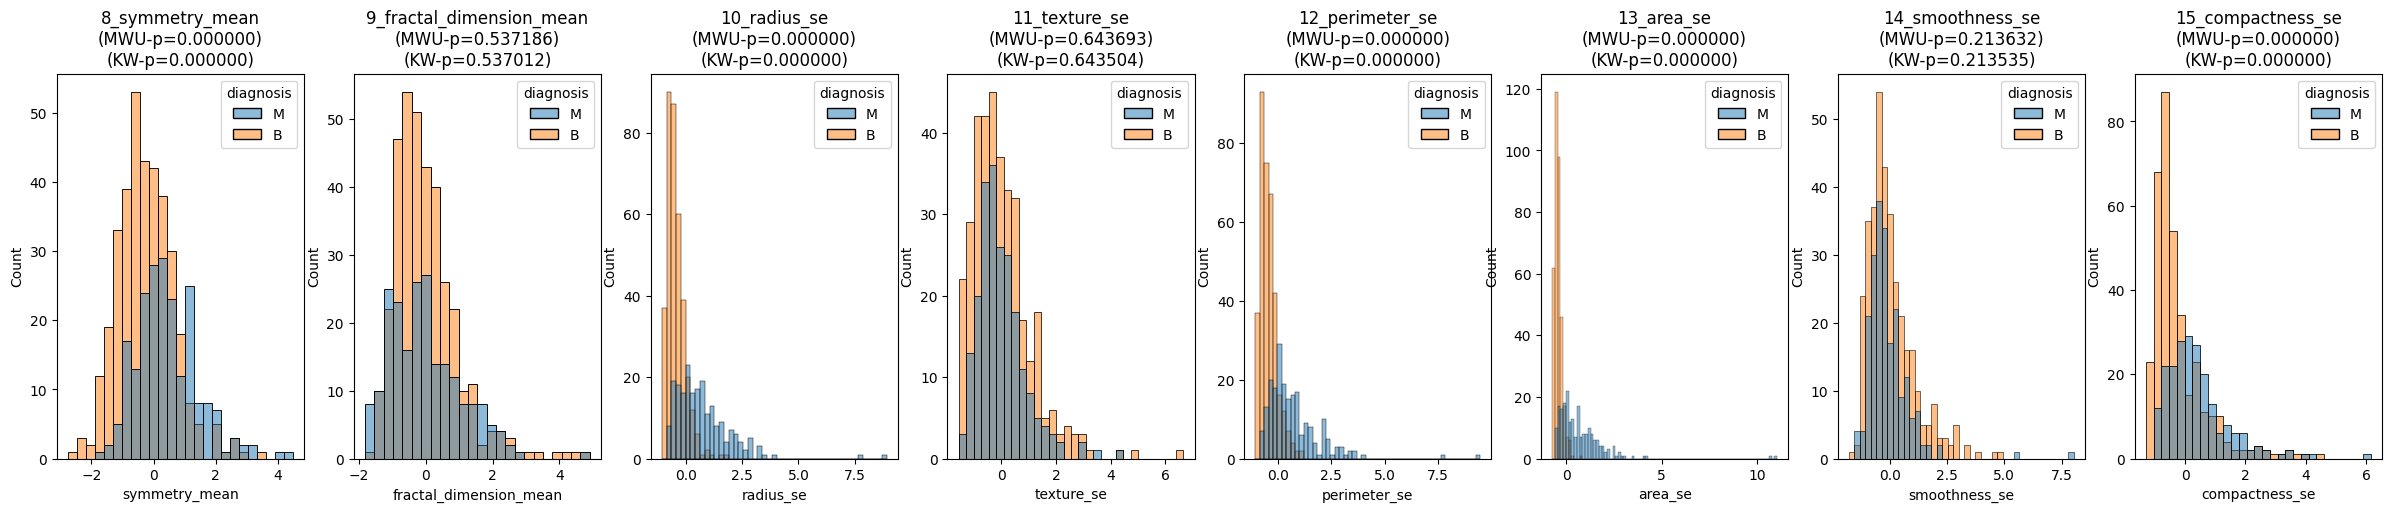

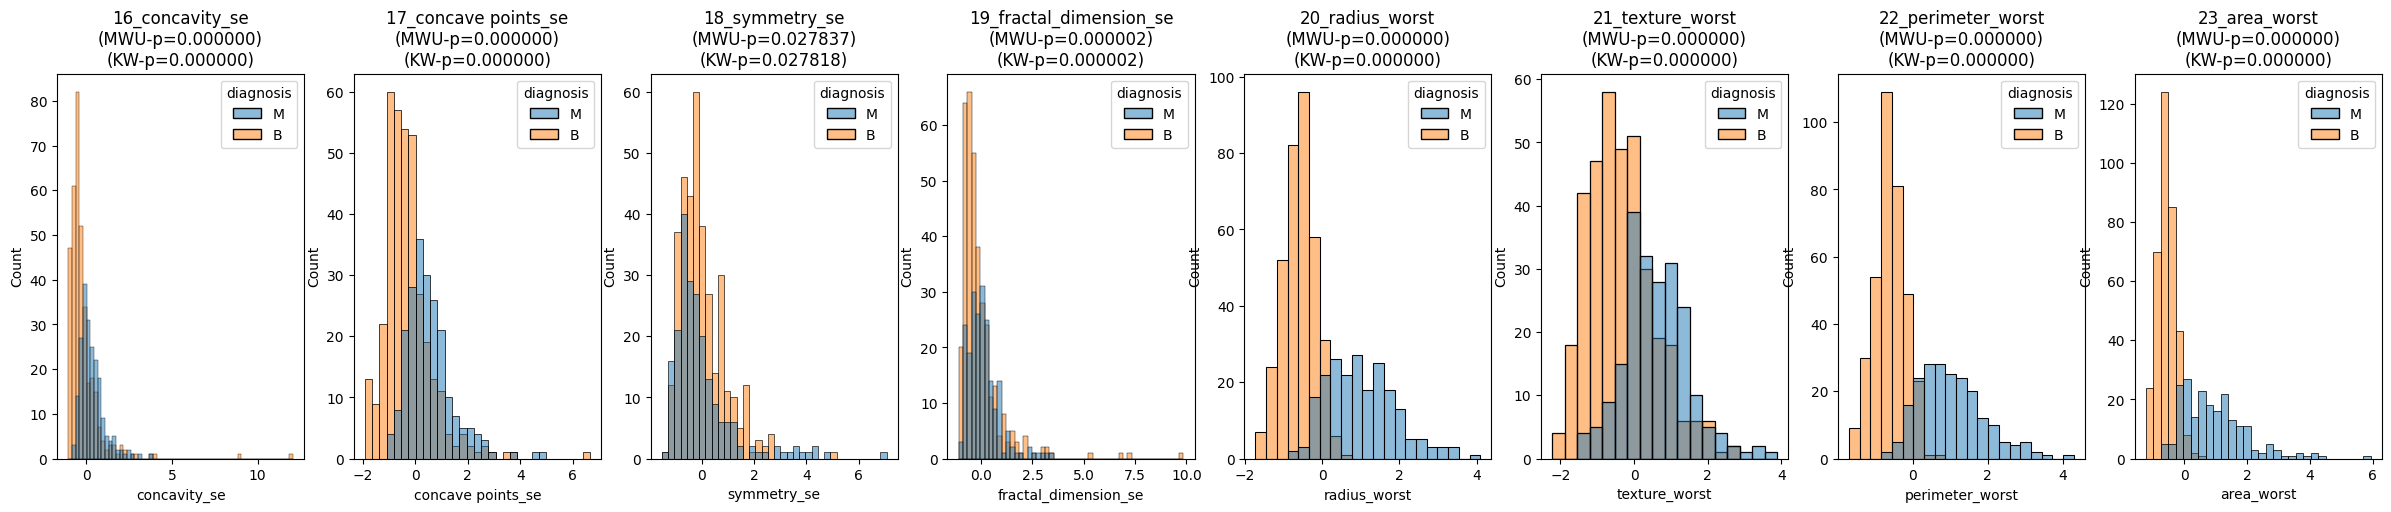

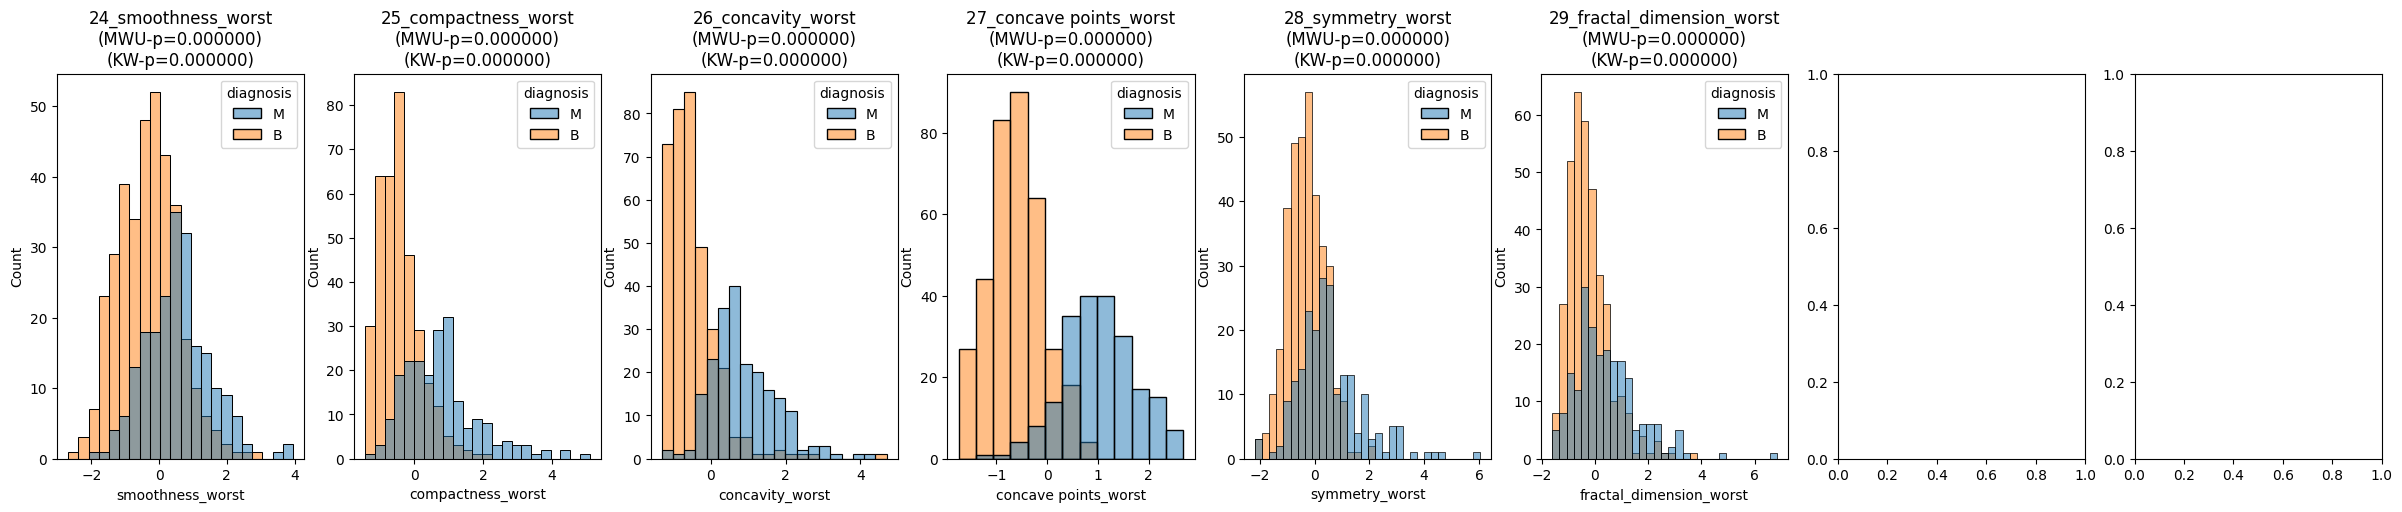

In [7]:
hypotest_discarded_feats = []
hypotest_selected_feats = []
feats_plot_range = [0,8]
f, axes = plt.subplots(1, 8, figsize=(30,5))
for idx, feature_name in enumerate(feature_names[feats_plot_range[0]:feats_plot_range[1]]):
    g = sns.histplot(df_scaled, x=feature_name, hue="diagnosis", ax=axes[idx])
    sel_mal = df_scaled['diagnosis'] == 'M'
    sel_ben = df_scaled['diagnosis'] != 'M'
    res_mwu = stats.mannwhitneyu(df_scaled[feature_name][sel_mal], df_scaled[feature_name][sel_ben])
    res_kw = stats.kruskal(df_scaled[feature_name][sel_mal], df_scaled[feature_name][sel_ben])
    g.set(title= f"{feats_plot_range[0]+idx}_{feature_name}\n(MWU-p={res_mwu.pvalue:.6f})\n(KW-p={res_kw.pvalue:.6f})")
    if res_mwu.pvalue > 0.001 or res_kw.pvalue > 0.001:
        hypotest_discarded_feats.append(feature_name)
    else:
        hypotest_selected_feats.append(feature_name)


feats_plot_range = [8,16]
f, axes = plt.subplots(1, 8, figsize=(30,5))
for idx, feature_name in enumerate(feature_names[feats_plot_range[0]:feats_plot_range[1]]):
    g = sns.histplot(df_scaled, x=feature_name, hue="diagnosis", ax=axes[idx])
    sel_mal = df_scaled['diagnosis'] == 'M'
    sel_ben = df_scaled['diagnosis'] != 'M'
    res_mwu = stats.mannwhitneyu(df_scaled[feature_name][sel_mal], df_scaled[feature_name][sel_ben])
    res_kw = stats.kruskal(df_scaled[feature_name][sel_mal], df_scaled[feature_name][sel_ben])
    g.set(title= f"{feats_plot_range[0]+idx}_{feature_name}\n(MWU-p={res_mwu.pvalue:.6f})\n(KW-p={res_kw.pvalue:.6f})")
    if res_mwu.pvalue > 0.001 or res_kw.pvalue > 0.001:
        hypotest_discarded_feats.append(feature_name)
    else:
        hypotest_selected_feats.append(feature_name)


feats_plot_range = [16,24]
f, axes = plt.subplots(1, 8, figsize=(30,5))
for idx, feature_name in enumerate(feature_names[feats_plot_range[0]:feats_plot_range[1]]):
    g = sns.histplot(df_scaled, x=feature_name, hue="diagnosis", ax=axes[idx])
    sel_mal = df_scaled['diagnosis'] == 'M'
    sel_ben = df_scaled['diagnosis'] != 'M'
    res_mwu = stats.mannwhitneyu(df_scaled[feature_name][sel_mal], df_scaled[feature_name][sel_ben])
    res_kw = stats.kruskal(df_scaled[feature_name][sel_mal], df_scaled[feature_name][sel_ben])
    g.set(title= f"{feats_plot_range[0]+idx}_{feature_name}\n(MWU-p={res_mwu.pvalue:.6f})\n(KW-p={res_kw.pvalue:.6f})")
    if res_mwu.pvalue > 0.001 or res_kw.pvalue > 0.001:
        hypotest_discarded_feats.append(feature_name)
    else:
        hypotest_selected_feats.append(feature_name)

feats_plot_range = [24,32]
f, axes = plt.subplots(1, 8, figsize=(30,5))
for idx, feature_name in enumerate(feature_names[feats_plot_range[0]:feats_plot_range[1]]):
    g = sns.histplot(df_scaled, x=feature_name, hue="diagnosis", ax=axes[idx])
    sel_mal = df_scaled['diagnosis'] == 'M'
    sel_ben = df_scaled['diagnosis'] != 'M'
    res_mwu = stats.mannwhitneyu(df_scaled[feature_name][sel_mal], df_scaled[feature_name][sel_ben])
    res_kw = stats.kruskal(df_scaled[feature_name][sel_mal], df_scaled[feature_name][sel_ben])
    g.set(title= f"{feats_plot_range[0]+idx}_{feature_name}\n(MWU-p={res_mwu.pvalue:.6f})\n(KW-p={res_kw.pvalue:.6f})")
    if res_mwu.pvalue > 0.001 or res_kw.pvalue > 0.001:
        hypotest_discarded_feats.append(feature_name)
    else:
        hypotest_selected_feats.append(feature_name)

# 4. Selection of features

##  4.1 Based on hypothesis testing

In [8]:
print("hypotest_discarded_feats:\n", hypotest_discarded_feats)
print("\n\nhypotest_selected_feats:\n", hypotest_selected_feats)
df_hypo = df_scaled.drop(columns=hypotest_discarded_feats, inplace=False)
df_hypo.head(5)

hypotest_discarded_feats:
 ['fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se']


hypotest_selected_feats:
 ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se', 'area_se', 'compactness_se', 'concavity_se', 'concave points_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,M,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,M,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,M,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,M,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


## 4.2 Based on PCA 

In [9]:
pca = PCA(n_components=0.95, svd_solver='full')
pca_data = pca.fit_transform(df_scaled[feature_names].to_numpy())
pca_feat_names = pca.get_feature_names_out()
print("Principal Components Explained Variance: ", np.sum(pca.explained_variance_ratio_))
print("Nr. of PCA Components: ", pca.n_components_)
print("PCA Feature NAmes:", pca_feat_names)
pca_data.shape
df_pca = df[['diagnosis']].copy()
df_pca[pca_feat_names] = pca_data
df_pca.head(5)

Principal Components Explained Variance:  0.9515688143366666
Nr. of PCA Components:  10
PCA Feature NAmes: ['pca0' 'pca1' 'pca2' 'pca3' 'pca4' 'pca5' 'pca6' 'pca7' 'pca8' 'pca9']


,diagnosis,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9
0,M,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402
1,M,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995
2,M,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275
3,M,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975
4,M,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704


<Axes: >

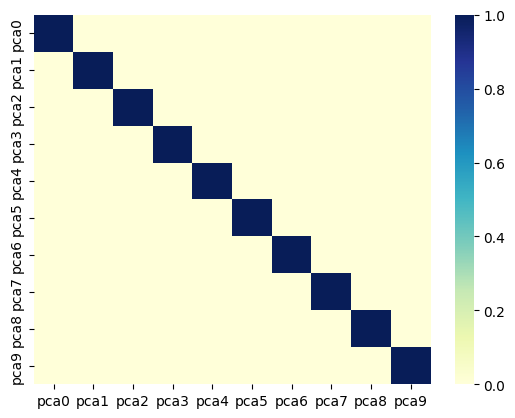

In [10]:
sns.heatmap(df_pca[pca_feat_names].corr(), cmap="YlGnBu", annot=False)

Text(0.5, 0.98, 'PCA Components Pairplot')

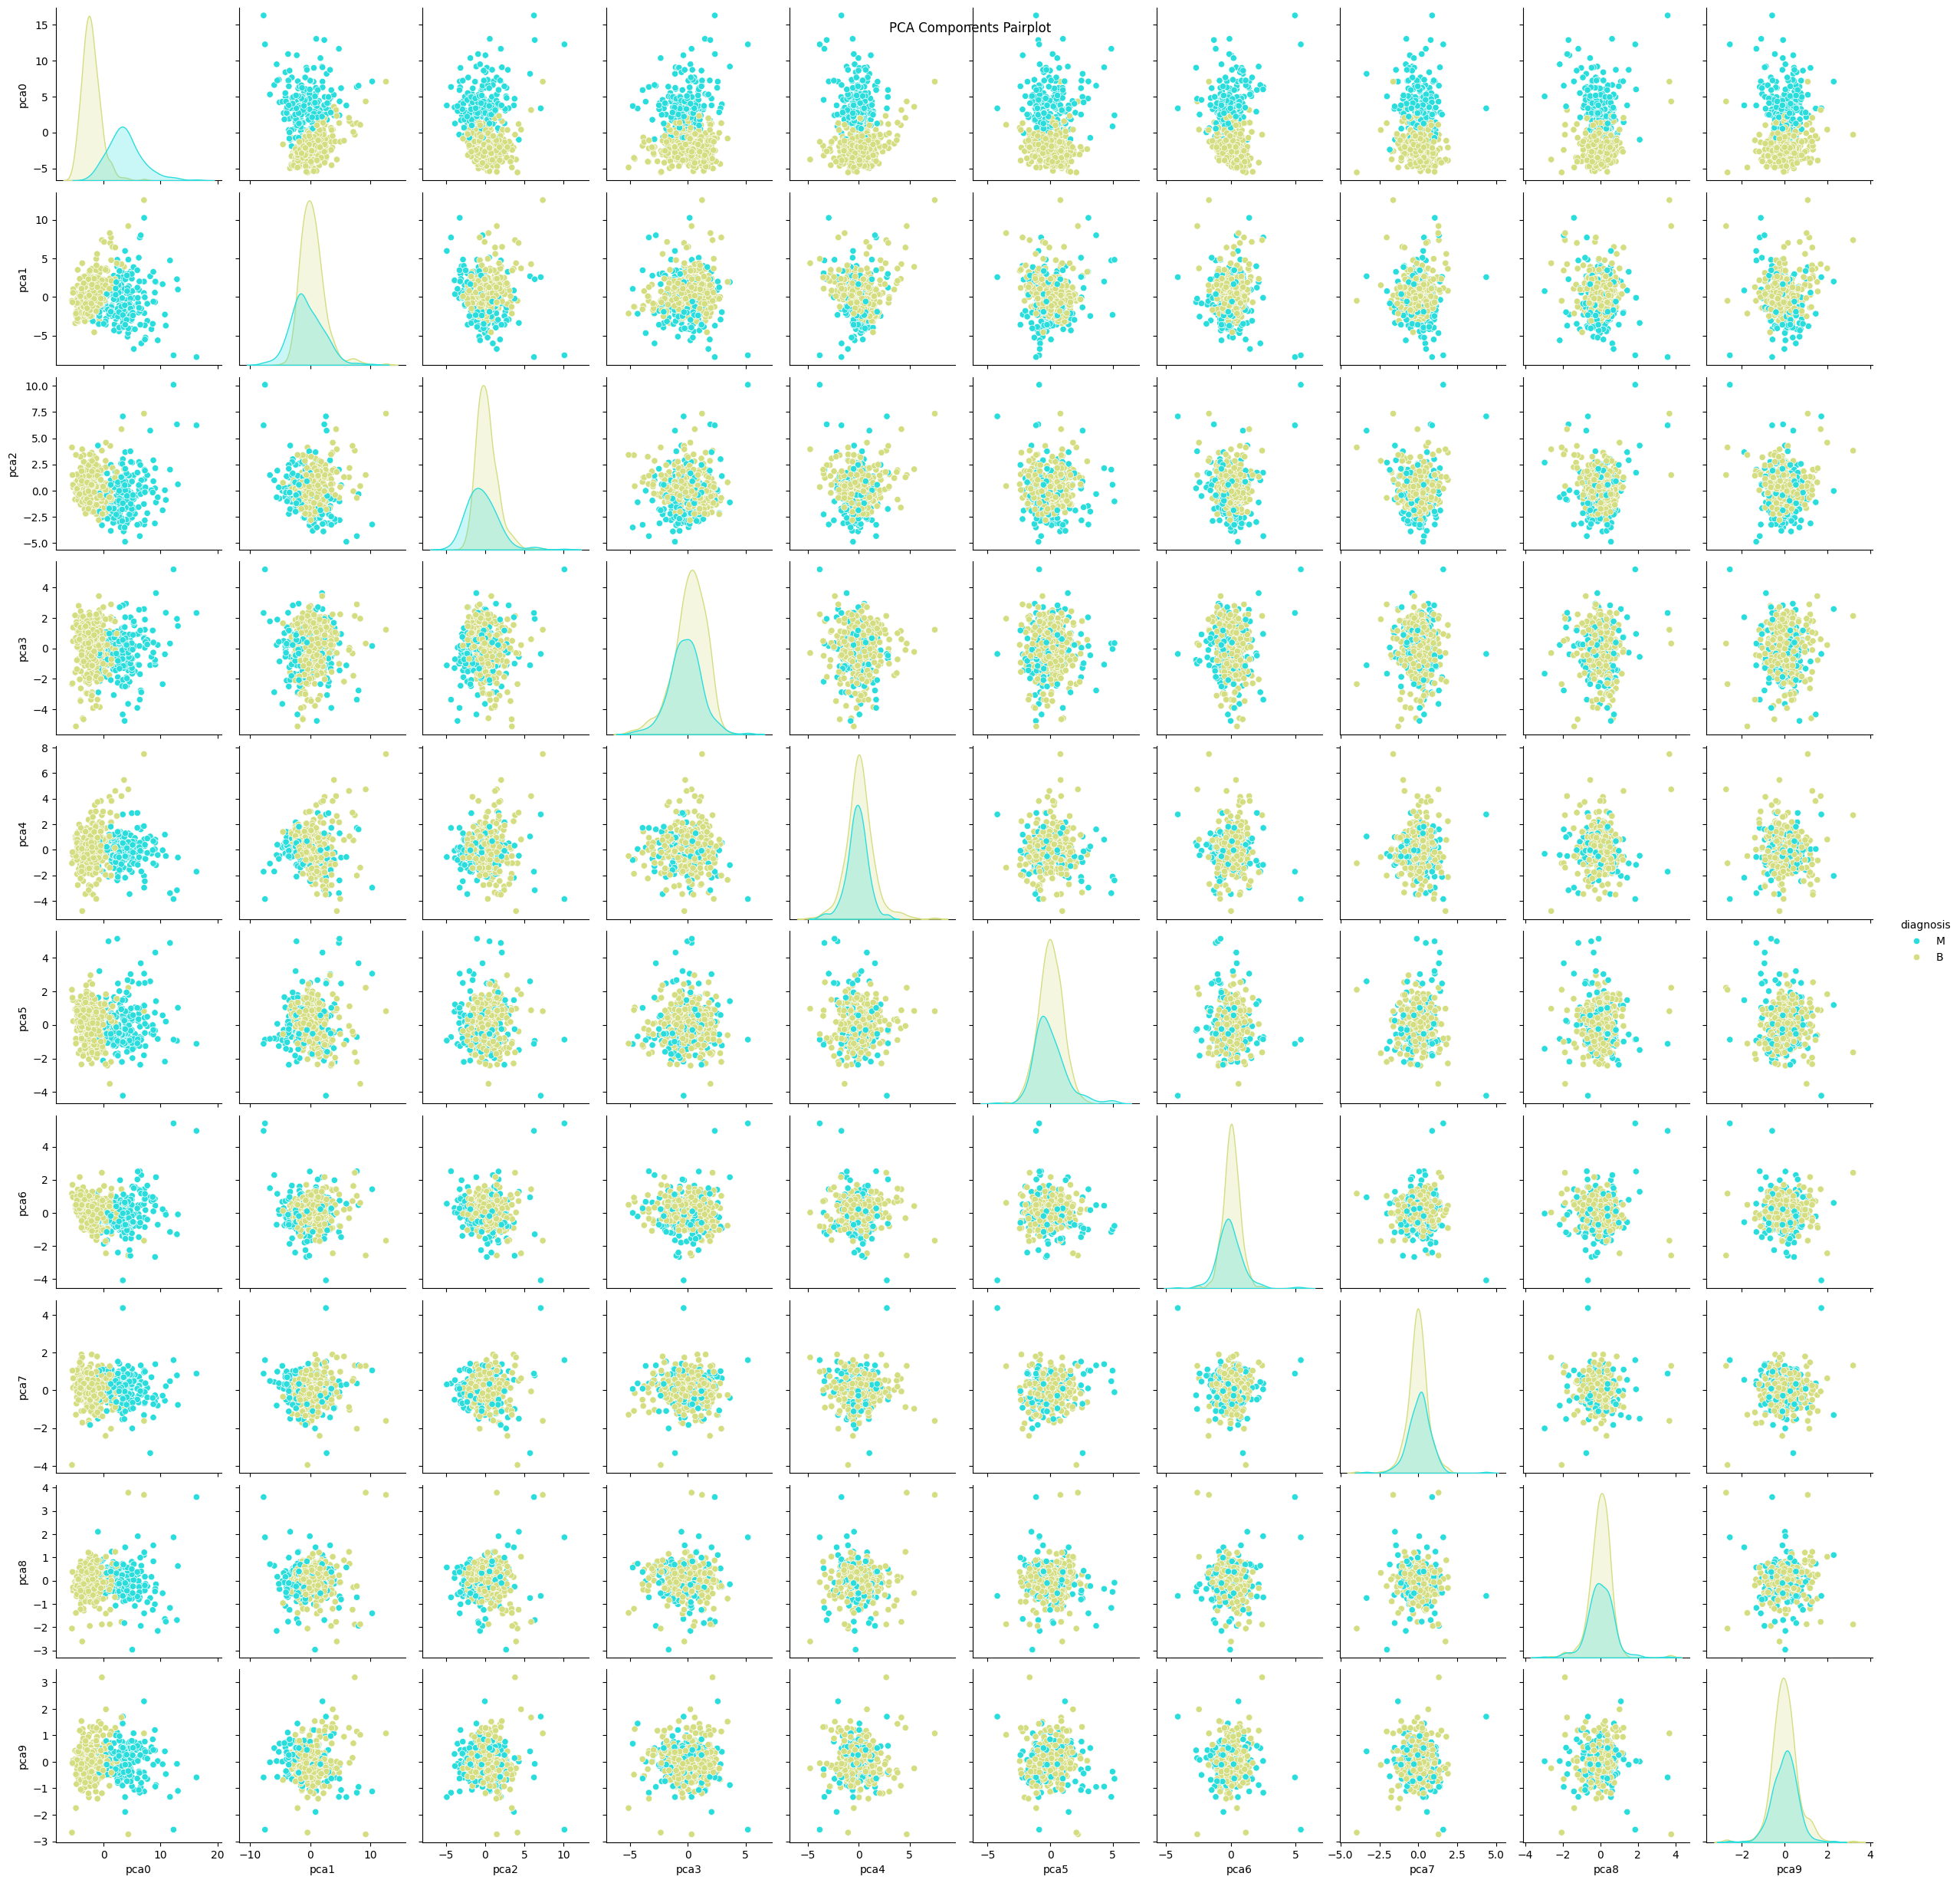

In [11]:
sns.pairplot(df_pca,hue="diagnosis",palette="rainbow")
plt.suptitle('PCA Components Pairplot')

# 5. Cluster the data using K-means

In [12]:
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [13]:
# Objective function for hyperparameter tuning of K-Means
def objective_kmeans(trial, X, n_clusters, random_state):
    params = {        
    "init": trial.suggest_categorical("init", ["k-means++", "random"]),
    "tol": trial.suggest_float("tol", 1e-9, 1e9, log=True),
    "algorithm": trial.suggest_categorical("algorithm", ["lloyd", "elkan"]),
    # Constants
    "n_clusters": trial.suggest_categorical("n_clusters", [n_clusters]),
    "n_init": trial.suggest_categorical("n_init", [10]),
    "max_iter": trial.suggest_categorical("max_iter", [1000]),
    "random_state": trial.suggest_categorical("random_state", [random_state]),
    }
    
    cluster_model = KMeans(**params).fit(X)
    silhouette_avg = silhouette_score(X, cluster_model.labels_)

    trial.set_user_attr("cluster_model", cluster_model)
    
    return silhouette_avg

## 5.1 Use the features selected using Hypothesis testing 

In [14]:
X = df_hypo.drop(columns=['diagnosis'], inplace=False).to_numpy()
#X = df_pca.drop(columns=['diagnosis'], inplace=False).to_numpy()
random_state = 42
best_silhouette_score = 0
best_inertia = 0
best_k = 2
best_trial = []
best_cluster_model  = []
silhouette_score_log = {'n_k':[], 'silhouette_score':[], 'inertia':[]}

for k in range(2,11):
    study = optuna.create_study(direction = "maximize")
    func = lambda trial: objective_kmeans(trial, X, k, random_state)
    study.optimize(func, n_trials = 100, timeout=600)
    silhouette_score_val = study.best_trial.value

    cluster_model = study.best_trial.user_attrs['cluster_model']
    inertia_val = cluster_model.inertia_
    silhouette_avg = silhouette_score(X, cluster_model.labels_)
    
    silhouette_score_log['n_k'].append(k)
    silhouette_score_log['silhouette_score'].append(silhouette_score_val)
    silhouette_score_log['inertia'].append(inertia_val)

    if silhouette_score_val > best_silhouette_score:
        best_silhouette_score = silhouette_score_val
        best_inertia = inertia_val
        best_k = k
        best_trial = study.best_trial
        best_cluster_model = cluster_model

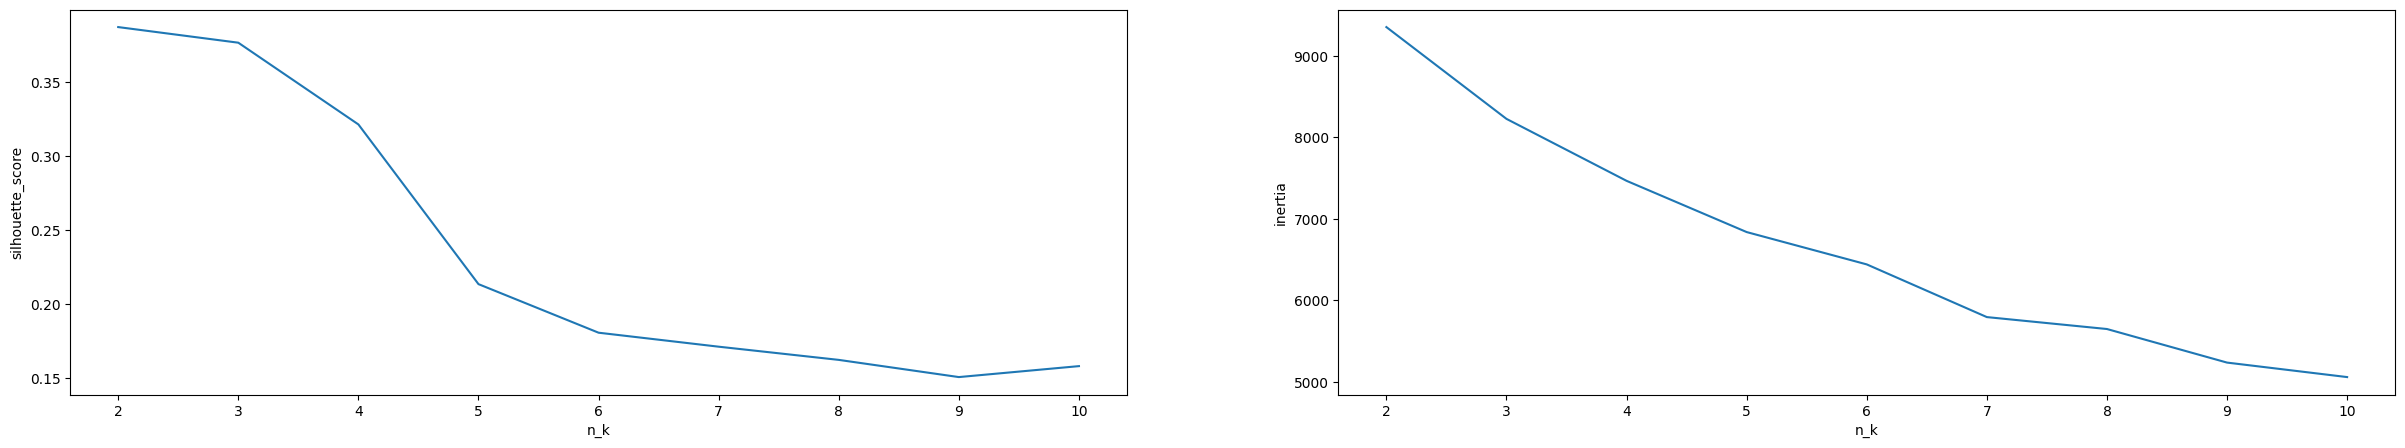

In [15]:
f, axes = plt.subplots(1, 2, figsize=(30,5))
sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='n_k', y='silhouette_score', ax=axes[0])
sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='n_k', y='inertia', ax=axes[1])
sns.set(font_scale=1)


In [16]:
print(f"The best Silhouette Score was = {best_silhouette_score:.2f} with K equals to {best_k} and an inertia of {best_inertia}\n")
print("First 10 sample labels are: ", best_cluster_model.labels_[:10])

print("Best Score Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

The best Silhouette Score was = 0.39 with K equals to 2 and an inertia of 9350.527599537829

First 10 sample labels are:  [0 0 0 0 0 0 0 0 0 0]
Best Score Params: 
    init: k-means++
    tol: 194.67196226566475
    algorithm: lloyd
    n_clusters: 2
    n_init: 10
    max_iter: 1000
    random_state: 42


## 5.1 Use the features selected using PCA

In [17]:
X = df_pca.drop(columns=['diagnosis'], inplace=False).to_numpy()
random_state = 42
best_silhouette_score = 0
best_inertia = 0
best_k = 2
best_trial = []
best_cluster_model  = []
silhouette_score_log = {'n_k':[], 'silhouette_score':[], 'inertia':[]}

for k in range(2,11):
    study = optuna.create_study(direction = "maximize")
    func = lambda trial: objective_kmeans(trial, X, k, random_state)
    study.optimize(func, n_trials = 100, timeout=600)
    silhouette_score_val = study.best_trial.value

    cluster_model = study.best_trial.user_attrs['cluster_model']
    inertia_val = cluster_model.inertia_
    silhouette_avg = silhouette_score(X, cluster_model.labels_)
    
    silhouette_score_log['n_k'].append(k)
    silhouette_score_log['silhouette_score'].append(silhouette_score_val)
    silhouette_score_log['inertia'].append(inertia_val)

    if silhouette_score_val > best_silhouette_score:
        best_silhouette_score = silhouette_score_val
        best_inertia = inertia_val
        best_k = k
        best_trial = study.best_trial
        best_cluster_model = cluster_model

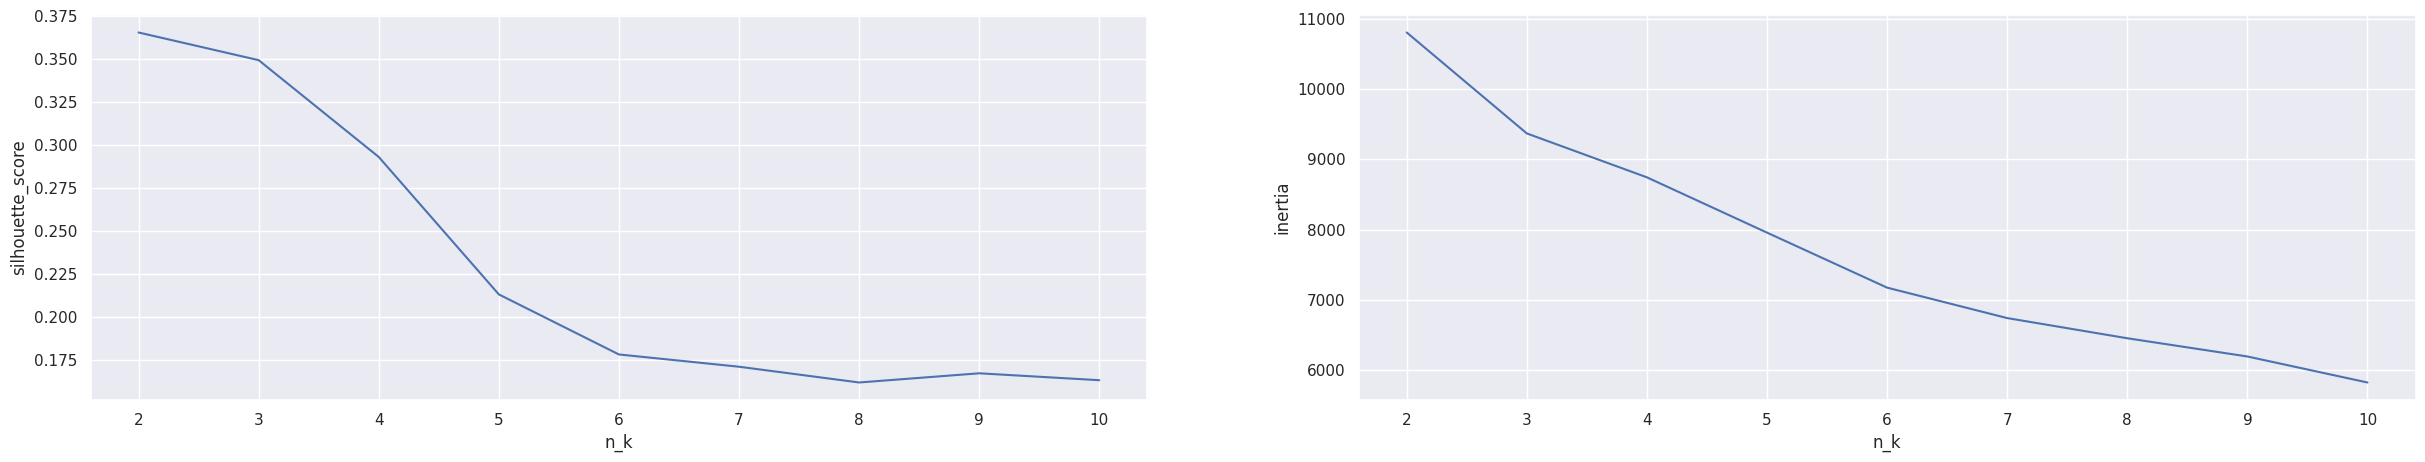

In [18]:
f, axes = plt.subplots(1, 2, figsize=(30,5))
sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='n_k', y='silhouette_score', ax=axes[0])
sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='n_k', y='inertia', ax=axes[1])
sns.set(font_scale=1)


In [19]:
print(f"The best Silhouette Score was = {best_silhouette_score:.2f} with K equals to {best_k} and an inertia of {best_inertia}\n")
print("First 10 sample labels are: ", best_cluster_model.labels_[:10])

print("Best Score Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

The best Silhouette Score was = 0.37 with K equals to 2 and an inertia of 10802.905705867215

First 10 sample labels are:  [1 1 1 1 1 1 1 1 1 1]
Best Score Params: 
    init: k-means++
    tol: 4186170.5067310906
    algorithm: lloyd
    n_clusters: 2
    n_init: 10
    max_iter: 1000
    random_state: 42


# 6. Cluster the data using Mean Shift Clustering

## 6.1 Use the features selected using Hypothesis testing 

In [20]:
X = df_hypo.drop(columns=['diagnosis'], inplace=False).to_numpy()
#X = df_pca.drop(columns=['diagnosis'], inplace=False).to_numpy()
random_state = 42
best_silhouette_score = 0
best_bw = 0
best_trial = []
best_cluster_model  = []
silhouette_score_log = {'bandwidth':[], 'silhouette_score':[]}


for quantile in np.arange(0.1,1,0.05):
    
    bandwidth = estimate_bandwidth(X, quantile=quantile, random_state=random_state, n_jobs=-1)
    msc_model = MeanShift(bandwidth=bandwidth, cluster_all=True, max_iter=1000, n_jobs=-1).fit(X)
    silhouette_score_val = silhouette_score(X, msc_model.labels_)

    silhouette_score_log['bandwidth'].append(bandwidth)
    silhouette_score_log['silhouette_score'].append(silhouette_score_val)

    if silhouette_score_val > best_silhouette_score:
        best_silhouette_score = silhouette_score_val
        best_bw = bandwidth
        best_msc_model = msc_model

The best Silhouette Score was = 0.65 with a bandwidth of 2



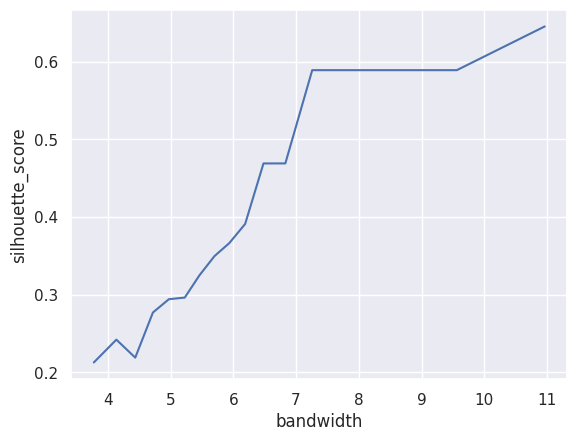

In [21]:
sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='bandwidth', y='silhouette_score')
sns.set(font_scale=1)
print(f"The best Silhouette Score was = {best_silhouette_score:.2f} with a bandwidth of {best_k}\n")

## 6.2 Use the features selected using PCA 

In [22]:
#X = df_hypo.drop(columns=['diagnosis'], inplace=False).to_numpy()
X = df_pca.drop(columns=['diagnosis'], inplace=False).to_numpy()
random_state = 42
best_silhouette_score = 0
best_bw = 0
best_msc_model  = []
silhouette_score_log = {'bandwidth':[], 'silhouette_score':[]}


for quantile in np.arange(0.1,1,0.05):
    
    bandwidth = estimate_bandwidth(X, quantile=quantile, random_state=random_state, n_jobs=-1)
    msc_model = MeanShift(bandwidth=bandwidth, cluster_all=True, max_iter=1000, n_jobs=-1).fit(X)
    silhouette_score_val = silhouette_score(X, msc_model.labels_)

    silhouette_score_log['bandwidth'].append(bandwidth)
    silhouette_score_log['silhouette_score'].append(silhouette_score_val)

    if silhouette_score_val > best_silhouette_score:
        best_silhouette_score = silhouette_score_val
        best_bw = bandwidth
        best_msc_model = msc_model

The best Silhouette Score was = 0.61 with a bandwidth of 2



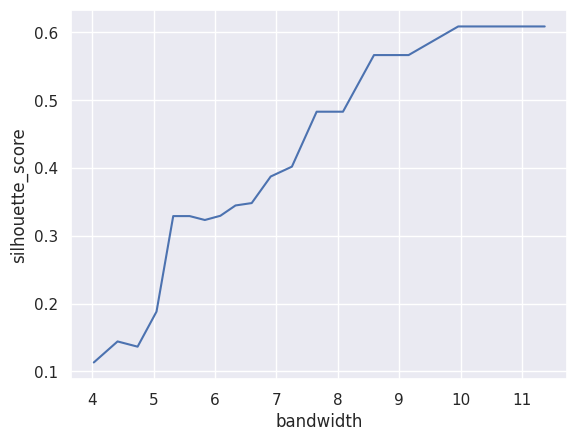

In [23]:
sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='bandwidth', y='silhouette_score')
sns.set(font_scale=1)
print(f"The best Silhouette Score was = {best_silhouette_score:.2f} with a bandwidth of {best_k}\n")

# 7. Cluster the data using DBSCAN

## 7.1 Use the features selected using Hypothesis testing 

In [24]:
X = df_hypo.drop(columns=['diagnosis'], inplace=False).to_numpy()
#X = df_pca.drop(columns=['diagnosis'], inplace=False).to_numpy()
random_state = 42
best_silhouette_score = 0
best_epsilon = 0
best_dbscan_model  = []
silhouette_score_log = {'epsilon':[], 'silhouette_score':[]}
nr_samples = X.shape[0]

for epsilon in np.arange(0.1,20,0.1):

    #dbscan_model = DBSCAN(eps=epsilon, min_samples=2).fit(X)
    dbscan_model = DBSCAN(eps=epsilon, min_samples=5).fit(X)
    labels = dbscan_model.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    n_clustered_points = nr_samples-n_noise_
    
    if n_clusters_ > 1:
        silhouette_score_val = silhouette_score(X, labels)
    
        silhouette_score_log['epsilon'].append(epsilon)
        silhouette_score_log['silhouette_score'].append(silhouette_score_val)
    
        if silhouette_score_val > best_silhouette_score:
            print("Estimated number of clusters: %d" % n_clusters_)
            print("Estimated number of clustered points: %d" % n_clustered_points)
            print("Estimated number of noise points: %d" % n_noise_)
            print(f"Silhouette Coefficient: {silhouette_score_val:.3f}")

            best_silhouette_score = silhouette_score_val
            best_epsilon = epsilon
            best_dbscan_model = dbscan_model

Estimated number of clusters: 4
Estimated number of clustered points: 341
Estimated number of noise points: 228
Silhouette Coefficient: 0.008
Estimated number of clusters: 2
Estimated number of clustered points: 392
Estimated number of noise points: 177
Silhouette Coefficient: 0.125
Estimated number of clusters: 2
Estimated number of clustered points: 500
Estimated number of noise points: 69
Silhouette Coefficient: 0.333


The best Silhouette Score was = 0.33 with an epsilon of 3.0000000000000004



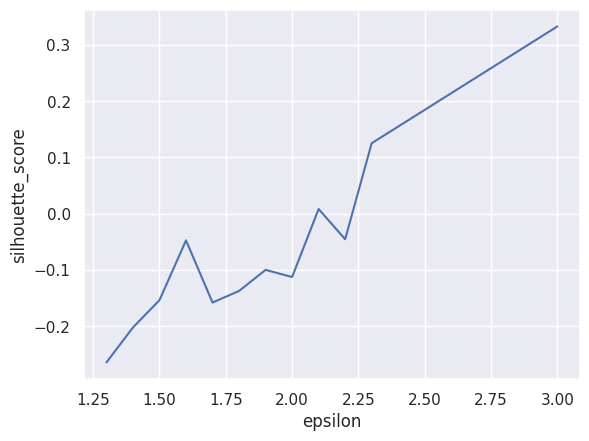

In [25]:
sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='epsilon', y='silhouette_score')
sns.set(font_scale=1)
print(f"The best Silhouette Score was = {best_silhouette_score:.2f} with an epsilon of {best_epsilon}\n")

## 7.2 Use the features selected using PCA 

In [26]:
#X = df_hypo.drop(columns=['diagnosis'], inplace=False).to_numpy()
X = df_pca.drop(columns=['diagnosis'], inplace=False).to_numpy()
random_state = 42
best_silhouette_score = 0
best_epsilon = 0
best_dbscan_model  = []
silhouette_score_log = {'epsilon':[], 'silhouette_score':[]}
nr_samples = X.shape[0]

for epsilon in np.arange(0.1,20,0.1):

    #dbscan_model = DBSCAN(eps=epsilon, min_samples=2).fit(X)
    dbscan_model = DBSCAN(eps=epsilon, min_samples=5).fit(X)
    labels = dbscan_model.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    n_clustered_points = nr_samples-n_noise_
    
    if n_clusters_ > 1:
        silhouette_score_val = silhouette_score(X, labels)
    
        silhouette_score_log['epsilon'].append(epsilon)
        silhouette_score_log['silhouette_score'].append(silhouette_score_val)
    
        if silhouette_score_val > best_silhouette_score:
            print("Estimated number of clusters: %d" % n_clusters_)
            print("Estimated number of clustered points: %d" % n_clustered_points)
            print("Estimated number of noise points: %d" % n_noise_)
            print(f"Silhouette Coefficient: {silhouette_score_val:.3f}")

            best_silhouette_score = silhouette_score_val
            best_epsilon = epsilon
            best_dbscan_model = dbscan_model

Estimated number of clusters: 2
Estimated number of clustered points: 465
Estimated number of noise points: 104
Silhouette Coefficient: 0.260
Estimated number of clusters: 2
Estimated number of clustered points: 471
Estimated number of noise points: 98
Silhouette Coefficient: 0.263


The best Silhouette Score was = 0.26 with an epsilon of 2.8000000000000003



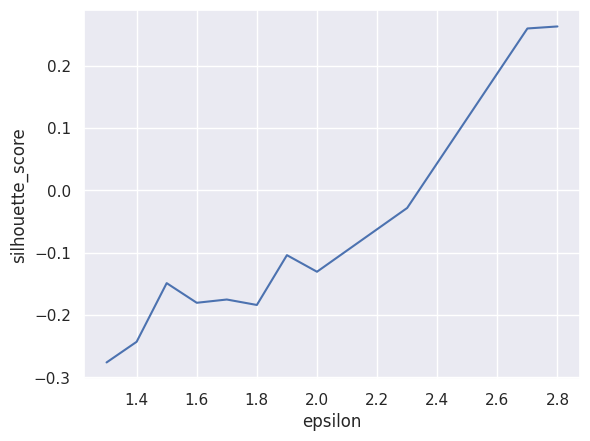

In [27]:
sns.lineplot(data=pd.DataFrame(silhouette_score_log), x='epsilon', y='silhouette_score')
sns.set(font_scale=1)
print(f"The best Silhouette Score was = {best_silhouette_score:.2f} with an epsilon of {best_epsilon}\n")